# SISTER Production Summary

In [49]:
import json
import os
import pandas as pd
import IPython
import datetime as dt 
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [50]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [51]:
crid= "002"
pattern = f"^SISTER.*{crid}$"
start = dt.datetime(2023, 5, 10, 0, 0)

### Cycle through jobs and store job information for tags matching regex pattern
_If duplicate tags exists only most recently run job is retained_

TODO: Retain all jobs, index by job ID instead of tag

In [52]:
production = {}

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]
    tag = tag.upper()

    if re.match(pattern,tag):

        job_info = {}
        job_info['status'] = job[job_id]['status'].replace('job-','')
        
        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'

        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')
        
        if 'time_queued' in job[job_id]['job']['job_info'].keys():
            queue_time = job[job_id]['job']['job_info']['time_queued']
        else:
            queue_time = '2000-01-01T00:00:00.0Z'  
        job_info['queue_time'] =dt.datetime.strptime(queue_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        instance_type = np.nan
        cores = np.nan
        memory = np.nan

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']

            if 'processorcount' in job[job_id]['job']['job_info']['facts'].keys():
                cores = job[job_id]['job']['job_info']['facts']['processorcount']

            if 'processorcount' in job[job_id]['job']['job_info']['facts'].keys():
                memorysize = float(job[job_id]['job']['job_info']['facts']['memorysize'].split()[0])
                memoryfree = float(job[job_id]['job']['job_info']['facts']['memoryfree'].split()[0])
                memory = memorysize - memoryfree

        job_info['instance_type'] = instance_type
        job_info['cores'] = cores
        job_info['memory'] = memory
        
        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])


        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage
        job_info['tag'] = tag

        
        if job_info['queue_time'] < start:
            continue
        if (tag not in production.keys()) | (job_info['status'] == 'completed'):
            production[tag] = job_info
        elif job_info['start_time'] > production[tag]['start_time']:
            production[tag] = job_info


## Create production results dataframe
---

In [53]:
production_df = pd.DataFrame(index = production.keys(),
                        columns = job_info.keys())

for tag in production.keys():
    production_df.loc[tag,:] = [production[tag][key] for key in job_info.keys()]
    
production_df['core_hours'] = production_df['cores']*(production_df['duration']/60)
    
prod_complete = pd.DataFrame(columns = production_df.columns)

for tag,group in  production_df[production_df.status != 'failed'].groupby(by ='tag'):
    index =np.argmax(group.end_time)
    group.iloc[index].name
    prod_complete.loc[group.iloc[index].tag,:] = group.iloc[index]
    
metrics = ['duration','inputs_disk_usage','staged_disk_usage','cores']   
prod_complete.index.name = 'tag'
prod_complete[['sensor','PGE']+metrics+['instance_type']].to_csv("./sister_production_run_3_metrics.csv")    

## Get job statistics by sensor and PGE

In [54]:
production_mean = prod_complete.groupby(['sensor','PGE']).mean()[metrics]
production_mode = prod_complete.groupby(['sensor','PGE']).agg( lambda x: pd.Series.mode(x)[0])['instance_type']
production_count = prod_complete.groupby(['sensor','PGE']).count()
production_mean

duration  inputs_disk_usage  staged_disk_usage  cores
sensor PGE                                                                    
AVCL   CWL             192.630881           0.000000           0.000000    2.0
       L1B_RDN          26.367931           3.146917           3.490445   36.0
       L2A_CORFL         5.732269           3.255144           3.108147    4.0
       L2A_RFL         167.060098           3.490445           6.593594   36.0
       L2A_RSRFL         6.111209           6.593594           6.211143    4.0
       L2B_AQUAPIG      24.461250           3.278309           0.002768    4.0
       L2B_BENTHCOVER    0.524378           0.399155           0.001026    4.0
       L2B_BENTHRFL     14.643288           3.278309           0.399155    4.0
       L2B_FRCOV        16.949444           3.108147           0.035694    4.0
       L2B_GRAINSIZE     1.321385           3.306693           0.000566    4.0
       L2B_VEGBIOCHEM    2.113313           3.278309           0.041191    4.0
AVNG   CWL             117.281480           0.000000           0.000000    2.0
       L1B_RDN          14.797607           8.427250           0.300307    4.0
       L2A_CORFL         0.744542           0.155561           0.140891    4.0
       L2A_RFL          62.789724           0.300225           0.566883   36.0
       L2A_RSRFL         0.706822           0.566883           0.281496    4.0
       L2B_AQUAPIG       3.948847           0.156576           0.000587    4.0
       L2B_BENTHCOVER    0.415106           0.019126           0.000241    4.0
       L2B_BENTHRFL      3.511366           0.156576           0.019126    4.0
       L2B_FRCOV        10.435602           0.140891           0.001869    4.0
       L2B_GRAINSIZE     0.612919           0.178719           0.000065    4.0
       L2B_VEGBIOCHEM    0.718187           0.153911           0.003223    4.0
DESIS  CWL              45.767711           0.000000           0.000000    2.0
       L1B_RDN           1.835594           0.565167           2.156578    4.0
       L2A_CORFL         0.555667           0.612758           0.525494    4.0
       L2A_RFL          22.564760           2.156578           4.084165   36.0
       L2A_RSRFL         1.704339           4.084165           1.048851    4.0
       L2B_AQUAPIG      17.944971           0.542090           0.007567    4.0
       L2B_BENTHCOVER    0.370399           0.229602           0.000868    4.0
       L2B_BENTHRFL     30.228201           0.542090           0.229602    4.0
       L2B_FRCOV        11.385861           0.525494           0.012362    4.0
       L2B_VEGBIOCHEM    0.724457           0.534482           0.004890    4.0
EMIT   CWL             249.314136           0.000000           0.000000    2.0
       L1B_RDN           7.564882           2.022322           4.962959   36.0
       L2A_CORFL         2.670852           3.765113           3.578708    4.0
       L2A_RFL          98.355813           5.069556           9.660636   36.0
       L2A_RSRFL         8.362624           9.660636           7.153273    4.0
       L2B_AQUAPIG      23.487888           3.710307           0.006427    4.0
       L2B_BENTHCOVER    0.735501           0.454222           0.002285    4.0
       L2B_BENTHRFL     34.115321           3.710307           0.454222    4.0
       L2B_FRCOV        15.825737           3.578708           0.027624    4.0
       L2B_GRAINSIZE     1.512913           3.949684           0.000474    4.0
       L2B_VEGBIOCHEM    2.468913           3.606332           0.035493    4.0
PRISMA CWL             164.352905           0.000000           0.000000    2.0
       L1B_RDN           6.352813           0.810349           1.401520    4.0
       L2A_CORFL         1.098940           1.274257           1.216643    4.0
       L2A_RFL          21.452502           1.400917           2.650162   36.0
       L2A_RSRFL         1.962621           2.650162           2.431339    4.0
       L2B_AQUAPIG      12.354944           1.235734           0.005093    

## Print CSV

In [71]:
PGEs = {'CWL':'CWL Workflow',
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOV':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

sensors = {'AVCL': 'AVIRIS-CL',
           'AVNG': 'AVIRIS-NG',
           'PRISMA':'PRISMA',
           'DESIS':'DESIS',
           'EMIT':'EMIT'}

for pge in PGEs.keys():
    for sensor in sensors.keys():
        if (sensor == 'DESIS') & (pge == 'L2B_GRAINSIZE'):
            continue
        else:
            row = production_mean.loc[(sensor,pge)].values.round(3).astype(str).tolist()
            instance_type = production_mode.loc[(sensor,pge)]
            count  = str(production_count.loc[(sensor,pge),'tag'])

            print(','.join([f'{PGEs[pge]} - {sensors[sensor]}'] + row + [instance_type,count]))


CWL Workflow - AVIRIS-CL,192.631,0.0,0.0,2.0,t3.medium,24
CWL Workflow - AVIRIS-NG,117.281,0.0,0.0,2.0,t3.medium,57
CWL Workflow - PRISMA,164.353,0.0,0.0,2.0,t3.medium,26
CWL Workflow - DESIS,45.768,0.0,0.0,2.0,t3.medium,8
CWL Workflow - EMIT,249.314,0.0,0.0,2.0,t3.medium,16
L1 Preprocess - AVIRIS-CL,26.368,3.147,3.49,36.0,c5.9xlarge,24
L1 Preprocess - AVIRIS-NG,14.798,8.427,0.3,4.0,t3.xlarge,61
L1 Preprocess - PRISMA,6.353,0.81,1.402,4.0,t3.xlarge,27
L1 Preprocess - DESIS,1.836,0.565,2.157,4.0,t3.xlarge,8
L1 Preprocess - EMIT,7.565,2.022,4.963,36.0,c5.9xlarge,20
L2 ISOFIT - AVIRIS-CL,167.06,3.49,6.594,36.0,c5.9xlarge,24
L2 ISOFIT - AVIRIS-NG,62.79,0.3,0.567,36.0,c5.9xlarge,57
L2 ISOFIT - PRISMA,21.453,1.401,2.65,36.0,c5.9xlarge,26
L2 ISOFIT - DESIS,22.565,2.157,4.084,36.0,c5.9xlarge,8
L2 ISOFIT - EMIT,98.356,5.07,9.661,36.0,c5.9xlarge,16
L2 Resample - AVIRIS-CL,6.111,6.594,6.211,4.0,t3.xlarge,24
L2 Resample - AVIRIS-NG,0.707,0.567,0.281,4.0,t3a.xlarge,57
L2 Resample - PRISMA,1.963,2.6

# Deliverable counts

In [72]:
deliverables = [
         'L2A_RSRFL',
         'L2A_CORFL',
         'L2B_FRCOV',
         'L2B_GRAINSIZE',
         'L2B_VEGBIOCHEM',         
         'L2B_BENTHRFL',
         'L2B_AQUAPIG',
         'L2B_BENTHCOVER',
         'L2B_VEGBIOCHEM']

deliver_df = prod_complete[[x in deliverables for x in prod_complete.PGE]]
deliver_count = deliver_df.groupby(['sensor','PGE']).count()
deliver_count[['tag']]

tag
sensor PGE                
AVCL   L2A_CORFL        24
       L2A_RSRFL        24
       L2B_AQUAPIG      23
       L2B_BENTHCOVER   23
       L2B_BENTHRFL     23
       L2B_FRCOV        24
       L2B_GRAINSIZE    22
       L2B_VEGBIOCHEM   23
AVNG   L2A_CORFL        57
       L2A_RSRFL        57
       L2B_AQUAPIG      49
       L2B_BENTHCOVER   49
       L2B_BENTHRFL     49
       L2B_FRCOV        57
       L2B_GRAINSIZE    34
       L2B_VEGBIOCHEM   50
DESIS  L2A_CORFL         8
       L2A_RSRFL         8
       L2B_AQUAPIG       6
       L2B_BENTHCOVER    6
       L2B_BENTHRFL      6
       L2B_FRCOV         8
       L2B_VEGBIOCHEM    7
EMIT   L2A_CORFL        16
       L2A_RSRFL        16
       L2B_AQUAPIG      13
       L2B_BENTHCOVER   13
       L2B_BENTHRFL     13
       L2B_FRCOV        16
       L2B_GRAINSIZE     9
       L2B_VEGBIOCHEM   16
PRISMA L2A_CORFL        26
       L2A_RSRFL        26
       L2B_AQUAPIG      20
       L2B_BENTHCOVER   20
       L2B_BENTHRFL     20
       L2B_FRCOV        26
       L2B_GRAINSIZE    17
       L2B_VEGBIOCHEM   26

In [73]:
print(f"Total production data volume: {prod_complete['staged_disk_usage'].sum()} Gb")
print(f"Total delivery data volume: {deliver_count['staged_disk_usage'].sum()} Gb")

Total production data volume: 1254.6252045950002 Gb
Total delivery data volume: 930 Gb


### Product counts

In [74]:
product_PGEs = {
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOV':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover'}

volume_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'tag':['count']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in volume_stats.loc[sensor].index: 
            pge_stats= volume_stats.loc[sensor].loc[pge].astype(float)

            stats+=pge_stats.values.astype(int).tolist()

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,24,24,24,24,24,22,23,23,23,23
AVNG,61,57,57,57,57,34,50,49,49,49
PRISMA,27,26,26,26,26,17,26,20,20,20
DESIS,8,8,8,8,8,7,6,6,6
EMIT,20,16,16,16,16,9,16,13,13,13


### Production data volume

In [75]:
product_PGEs = {
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOV':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover'}

volume_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'staged_disk_usage':['sum','mean']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in volume_stats.loc[sensor].index: 
            pge_stats= volume_stats.loc[sensor].loc[pge].astype(float)

            stats+=pge_stats.round(2).values.tolist()
            stats.append(" ")

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,83.77,3.49, ,158.25,6.59, ,149.07,6.21, ,74.6,3.11, ,0.86,0.04, ,0.01,0.0, ,0.95,0.04, ,9.18,0.4, ,0.06,0.0, ,0.02,0.0, 
AVNG,18.32,0.3, ,32.31,0.57, ,16.05,0.28, ,8.03,0.14, ,0.11,0.0, ,0.0,0.0, ,0.16,0.0, ,0.94,0.02, ,0.03,0.0, ,0.01,0.0, 
PRISMA,37.84,1.4, ,68.9,2.65, ,63.21,2.43, ,31.63,1.22, ,0.26,0.01, ,0.01,0.0, ,0.23,0.01, ,3.03,0.15, ,0.1,0.01, ,0.03,0.0, 
DESIS,17.25,2.16, ,32.67,4.08, ,8.39,1.05, ,4.2,0.53, ,0.1,0.01, ,0.03,0.0, ,1.38,0.23, ,0.05,0.01, ,0.01,0.0, 
EMIT,99.26,4.96, ,154.57,9.66, ,114.45,7.15, ,57.26,3.58, ,0.44,0.03, ,0.0,0.0, ,0.57,0.04, ,5.9,0.45, ,0.08,0.01, ,0.03,0.0, 


### Job duration table

In [77]:
product_PGEs = {
         'L1B_RDN':'L1B Preprocess',
         'L2A_RFL':'L2A ISOFIT',
         'L2A_RSRFL' :'L2A Resample',
         'L2A_CORFL':'L2A Correction',
         'L2B_FRCOV':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'CWL':'CWL Workflow',}

duration_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'duration':['min','mean','max']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in duration_stats.loc[sensor].index: 
            pge_stats= duration_stats.loc[sensor].loc[pge]

            stats+=pge_stats.round(1).values.tolist()
            stats.append(" ")
        else:
            stats+=['0','0','0'," "]

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,4.1,26.4,104.2, ,49.6,167.1,261.5, ,0.4,6.1,17.7, ,0.4,5.7,18.6, ,8.6,16.9,24.4, ,0.2,1.3,3.3, ,0.3,2.1,4.2, ,1.9,14.6,55.1, ,2.0,24.5,64.8, ,0.2,0.5,1.9, ,5.4,192.6,443.8, 
AVNG,4.2,14.8,50.5, ,13.2,62.8,139.5, ,0.2,0.7,1.7, ,0.2,0.7,1.7, ,8.4,10.4,13.2, ,0.1,0.6,1.4, ,0.2,0.7,2.0, ,0.7,3.5,9.2, ,0.9,3.9,10.3, ,0.1,0.4,1.5, ,6.7,117.3,276.7, 
PRISMA,5.3,6.4,8.1, ,14.2,21.5,40.5, ,1.6,2.0,3.4, ,0.9,1.1,2.4, ,10.5,12.3,15.7, ,0.1,0.8,1.8, ,0.7,1.1,2.3, ,1.5,22.5,106.2, ,5.2,12.4,23.7, ,0.2,0.3,0.7, ,103.0,164.4,265.2, 
DESIS,1.4,1.8,2.4, ,14.1,22.6,36.0, ,1.5,1.7,2.1, ,0.5,0.6,0.6, ,10.0,11.4,14.4, ,0,0,0, ,0.5,0.7,1.4, ,5.1,30.2,56.3, ,13.6,17.9,20.2, ,0.3,0.4,0.8, ,6.1,45.8,130.7, 
EMIT,3.8,7.6,19.1, ,60.0,98.4,228.3, ,5.7,8.4,15.8, ,1.9,2.7,4.2, ,13.2,15.8,19.7, ,0.9,1.5,3.3, ,1.6,2.5,3.6, ,2.8,34.1,139.9, ,7.6,23.5,43.5, ,0.4,0.7,1.2, ,6.7,249.3,615.7, 


L2A ISOFIT,6.883,32.962
L2 Aquatic Pigments,0.393,0.287
L2 Benth Cover,0.035,0.024
L2 Benth Rfl,0.392,0.389
L2B Fractional Cover,0.12,0.686
L2B Snow grain size,0.019,0.031
L2 Vegetation Traits,0.031,0.041


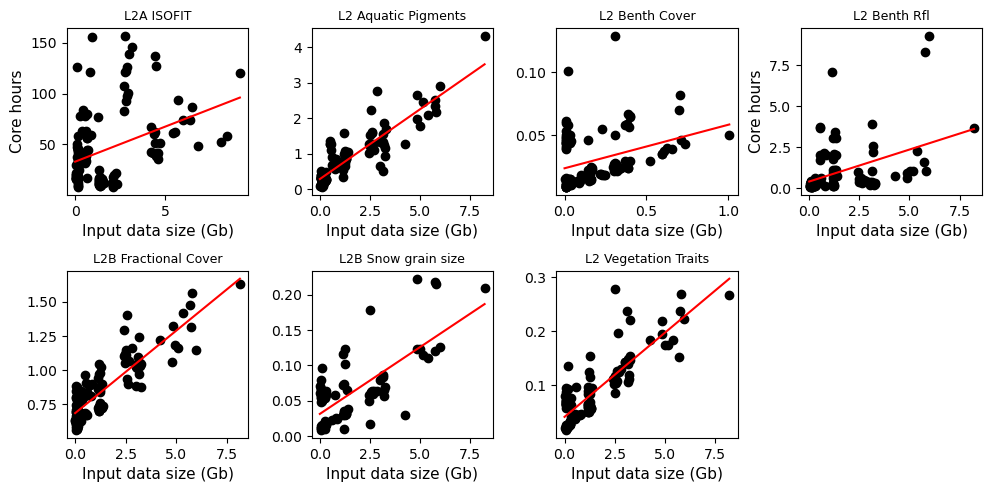

In [104]:
PGEs = {'L2A_RFL':'L2A ISOFIT',
         'L2B_FRCOV':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

fig = plt.figure(figsize = (10,5))
a = 1
for p,pge in prod_complete.groupby(by = 'PGE'):
    if p in PGEs.keys():

        x =pge['inputs_disk_usage'].values.astype(float)
        y =pge['core_hours'].values.astype(float)

        predict_x =np.linspace(0,x.max())

        model = sm.OLS(y,sm.add_constant(x)).fit()
        b0,b1 = model.params
        print(','.join([PGEs[p],str(round(b1,3)),str(round(b0,3))]))
                
        predict_y = model.predict(sm.add_constant(predict_x))

        equation = f'y = {b1}x + {b0}'

        ax = fig.add_subplot(2,4,a)
        ax.set_title(PGEs[p],fontsize = 9)

        ax.scatter(x,y,c = 'k')
        ax.plot(predict_x,predict_y,c = 'r')
        if a in [1,4]:
            ax.set_ylabel('Core hours',fontsize = 11)
        ax.set_xlabel('Input data size (Gb)',fontsize = 11)
        a+=1
        
fig.tight_layout(pad=1.0)    

plt.savefig(f'./input_v_core_hours.png',
            dpi = 300, bbox_inches= 'tight')


L2A ISOFIT,1.898,-0.005
L2 Aquatic Pigments,0.001,0.001
L2 Benth Cover,0.004,0.0
L2 Benth Rfl,0.12,0.013
L2B Fractional Cover,0.009,0.002
L2B Snow grain size,0.0,0.0
L2 Vegetation Traits,0.01,0.001


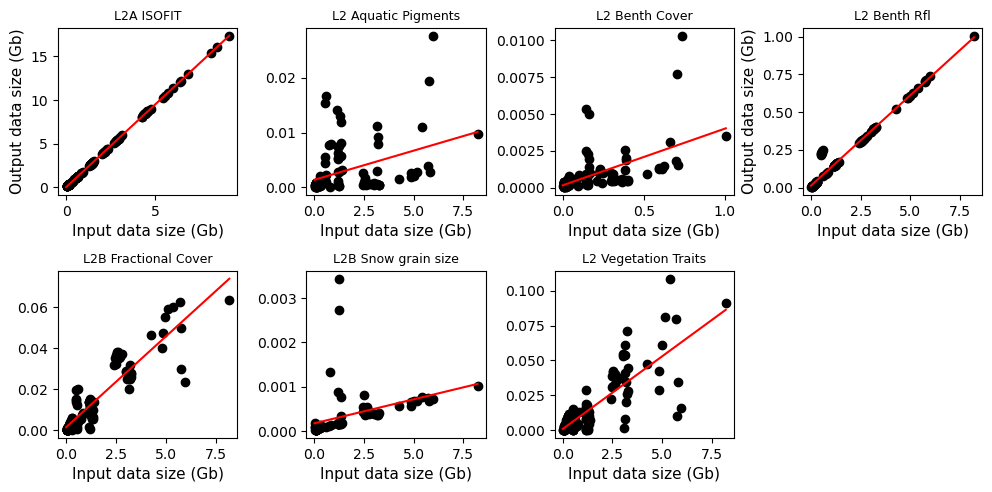

In [103]:
PGEs = {'L2A_RFL':'L2A ISOFIT',
         'L2B_FRCOV':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',         
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

fig = plt.figure(figsize = (10,5))
a = 1
    
for p,pge in prod_complete.groupby(by = 'PGE'):
    if p in PGEs.keys():

        x =pge['inputs_disk_usage'].values.astype(float)
        y =pge['staged_disk_usage'].values.astype(float)

        predict_x =np.linspace(0,x.max())

        model = sm.OLS(y,sm.add_constant(x)).fit()
        b0,b1 = model.params
        print(','.join([PGEs[p],str(round(b1,3)),str(round(b0,3))]))
                
        predict_y = model.predict(sm.add_constant(predict_x))

        equation = f'y = {b1}x + {b0}'

        ax = fig.add_subplot(2,4,a)
        ax.set_title(PGEs[p],fontsize = 9)

        ax.scatter(x,y,c = 'k')
        ax.plot(predict_x,predict_y,c = 'r')
        if a in [1,4]:
            ax.set_ylabel('Output data size (Gb)',fontsize = 11)
        ax.set_xlabel('Input data size (Gb)',fontsize = 11)
        a+=1
        
fig.tight_layout(pad=1.0)    

plt.savefig(f'./input_v_output_data.png',
            dpi = 300, bbox_inches= 'tight')
    
    